## Air Pollution Forecasting using LSTM
Based on Jason Brownlee's tutorial: [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)

In [43]:
from matplotlib import pyplot
from sklearn import preprocessing
from pandas import concat
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Embedding
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

Make sure the pollution.csv file is already created. Otherwise, you need to run first the data preparation script 'Data_prep'. 

Let's now plot the time series we have in this dataset.

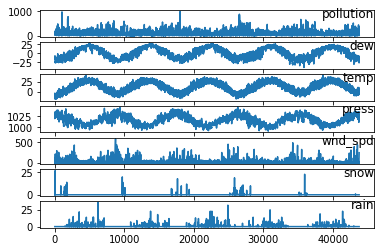

In [51]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
    
pyplot.show()
%matplotlib inline

## LSTM Data Preparation:

In [66]:
# convert series to supervised learning
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

# integer encode wind direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = values; #scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

print(reframed.shape)
print(reframed.head())

(43799, 9)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      129.0      -16.0       -4.0     1020.0        2.0       1.79   
2      148.0      -15.0       -4.0     1020.0        2.0       2.68   
3      159.0      -11.0       -5.0     1021.0        2.0       3.57   
4      181.0       -7.0       -5.0     1022.0        2.0       5.36   
5      138.0       -7.0       -5.0     1022.0        2.0       6.25   

   var7(t-1)  var8(t-1)  var1(t)  
1        0.0        0.0    148.0  
2        0.0        0.0    159.0  
3        0.0        0.0    181.0  
4        1.0        0.0    138.0  
5        2.0        0.0    109.0  


In [67]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features] as expected by LSTM cells
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


## Design LSTM Network

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0637 - val_loss: 0.0559
Epoch 2/50
 - 1s - loss: 0.0439 - val_loss: 0.0644
Epoch 3/50
 - 1s - loss: 0.0278 - val_loss: 0.0605
Epoch 4/50
 - 1s - loss: 0.0189 - val_loss: 0.0513
Epoch 5/50
 - 1s - loss: 0.0167 - val_loss: 0.0395
Epoch 6/50
 - 1s - loss: 0.0159 - val_loss: 0.0304
Epoch 7/50
 - 1s - loss: 0.0151 - val_loss: 0.0217
Epoch 8/50
 - 1s - loss: 0.0150 - val_loss: 0.0195
Epoch 9/50
 - 1s - loss: 0.0148 - val_loss: 0.0185
Epoch 10/50
 - 1s - loss: 0.0147 - val_loss: 0.0175
Epoch 11/50
 - 1s - loss: 0.0147 - val_loss: 0.0166
Epoch 12/50
 - 1s - loss: 0.0146 - val_loss: 0.0157
Epoch 13/50
 - 1s - loss: 0.0147 - val_loss: 0.0153
Epoch 14/50
 - 1s - loss: 0.0146 - val_loss: 0.0144
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0143
Epoch 16/50
 - 1s - loss: 0.0146 - val_loss: 0.0140
Epoch 17/50
 - 1s - loss: 0.0147 - val_loss: 0.0140
Epoch 18/50
 - 1s - loss: 0.0145 - val_loss: 0.0141
Epoch 19/50
 - 1s - loss

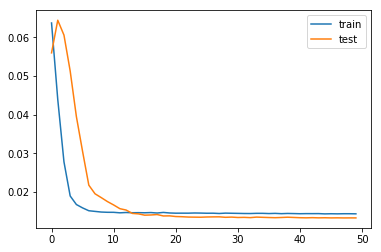

In [48]:
# design network
model = Sequential()
# 50 neurons in the first hidden layer
# The input shape will be 1 time step with 8 features
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# one neuron in the output layer
model.add(Dense(1))
# Mean Absolute Error (MAE) loss function and Adam for stochastic gradient descent
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [49]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [50]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert normalization of forecasted values
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert normalization of actual values
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.358
